In [3]:
import os
import psycopg
import pandas as pd

TABLE_NAME = 'flats_clean_table'

os.environ["DB_DESTINATION_HOST"] = os.getenv("DB_DESTINATION_HOST")
os.environ["DB_DESTINATION_PORT"] = os.getenv("DB_DESTINATION_PORT")
os.environ["DB_DESTINATION_NAME"] = os.getenv("DB_DESTINATION_NAME")
os.environ["DB_DESTINATION_USER"] = os.getenv("DB_DESTINATION_USER")
os.environ["DB_DESTINATION_PASSWORD"] = os.getenv("DB_DESTINATION_PASSWORD")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['price'], test_size=0.2, random_state=42)
num_columns = ['floor', 'kitchen_area', 'living_area', 'rooms',
               'total_area', 'build_year', 'building_type_int', 
               'latitude', 'longitude', 'ceiling_height', 'flats_count',
               'floors_total']
cat_columns = ['is_apartment','has_elevator']

Previous model fit:

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import json

preprocessor = ColumnTransformer(
    [
        ('num_cols_norm', StandardScaler(), num_columns),
        ('cat_cols_encode', OneHotEncoder(drop='if_binary'), cat_columns)
    ]
)
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)
metrics = {}
mae = mean_absolute_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
metrics['mae'] = mae
metrics['r2'] = r2
with open('metrics.json', 'w') as f:
    json.dump(metrics, f)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)

num_columns = ['floor', 'kitchen_area', 'living_area', 'rooms',
               'total_area', 'build_year', 'building_type_int', 
               'latitude', 'longitude', 'ceiling_height', 'flats_count',
               'floors_total']
cat_columns = ['is_apartment','has_elevator']

encoder_oh = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, drop='first')
encoder_spl = SplineTransformer(n_knots=3, degree=4)
encoder_q = QuantileTransformer(n_quantiles=100)
encoder_rb = RobustScaler()
encoder_pol = PolynomialFeatures(degree=3)
encoder_kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None)

transformer = ColumnTransformer(
  transformers=[
      ('encoder', encoder_oh, cat_columns),
      ('spl', encoder_spl, num_columns), 
      ('q', encoder_q, num_columns), 
      ('rb', encoder_rb, num_columns), 
      ('pol', encoder_pol, num_columns), 
      ('kbd', encoder_kbd, num_columns)
  ], n_jobs=-1
)


In [7]:
pipeline_fe = Pipeline(
    [
        ('preprocessor', transformer),
        ('model', model)
    ]
)
pipeline_fe.fit(X_train, y_train)
prediction_fe = pipeline_fe.predict(X_test)
metrics_fe = {}
mae = mean_absolute_error(y_test, prediction_fe)
r2 = r2_score(y_test, prediction_fe)
metrics_fe['mae'] = mae
metrics_fe['r2'] = r2

In [8]:
from autofeat import AutoFeatRegressor
autofeat = AutoFeatRegressor(feateng_steps=2, max_gb=16, transformations=['1+', 'sqrt', 'abs'])

In [9]:
autofeat_tr = ColumnTransformer(
    transformers=[
        ("autofeat", autofeat, num_columns)
    ]
)

In [10]:
X_train_features = transformer.fit_transform(X_train, y_train)
new_X_train = autofeat_tr.fit_transform(X_train, y_train)
model.fit(new_X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
X_test_features = transformer.transform(X_test)
new_X_test = autofeat_tr.transform(X_test)
prediction_fe_af = model.predict(new_X_test)

In [12]:

metrics_fe_af = {}
mae = mean_absolute_error(y_test, prediction_fe_af)
r2 = r2_score(y_test, prediction_fe_af)
metrics_fe_af['mae'] = mae
metrics_fe_af['r2'] = r2

In [13]:
metrics_fe

{'mae': 2728784.2941824845, 'r2': -23.035239494064083}

In [14]:
metrics_fe_af

{'mae': 2678611.822445238, 'r2': -8.197647554704382}

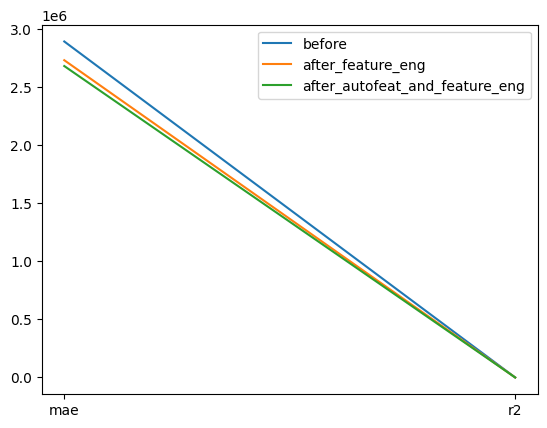

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

ASSETS_DIR = '../assets'
os.makedirs(ASSETS_DIR, exist_ok=True)

sns.lineplot(metrics, label='before')
sns.lineplot(metrics_fe, label = 'after_feature_eng')
sns.lineplot(metrics_fe_af, label = 'after_autofeat_and_feature_eng')
plt.savefig(os.path.join(ASSETS_DIR,'metrics_improvement'))

In [16]:
import mlflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(tracking_uri)

In [17]:
EXPERIMENT_NAME = "yandex_realty_aleksandra"
REGISTRY_MODEL_NAME = "better_model_aleksandra"
RUN_NAME = 'save_better_model'

In [19]:

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(new_X_test, prediction_fe_af)
input_example = X_test[:10]
metadata = {'model_type': 'monthly'}

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not (experiment_id):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment_id.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # ваш код здесь
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        pip_requirements=pip_requirements,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        artifact_path='models',
        await_registration_for=60
    )
    mlflow.log_metrics(metrics=metrics_fe_af)
    mlflow.log_artifact(ASSETS_DIR)
    


2025-01-16 06:18:41,234 INFO: Found credentials in environment variables.
Successfully registered model 'better_model_aleksandra'.
2025/01/16 06:18:41 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: better_model_aleksandra, version 1
Created version '1' of model 'better_model_aleksandra'.


In [20]:
run_id

'e87400ce4ceb4c0ea103efb6bb4c69fe'